In [1]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
   """Multiply two numbers."""
   return a * b

In [5]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model = "llama3.2:latest",
    temperature = 0.8,
    num_predict = 256,
)
llm_with_tools = llm.bind_tools([multiply])

In [7]:
messages = [
    ("system", "You are a helpful translator. Translate the user sentence to French."),
    ("human", "I love programming."),
]
response = llm.invoke(messages)

In [8]:
response.content

'Je adore la programmation. \n\n(Note: "Je" is the pronoun for "I", and "adore" means "to love". The verb conjugation is similar to English, but with a different ending in French.)'

### What is TypedDict
A TypedDict type represents dictionary objects with a specific set of string keys, and with specific value types for each valid key. Each string key can be either required (it must be present) or non-required (it doesn’t need to exist).


Annotated in python allows developers to declare the type of a reference and provide additional information related to it.

name: Annotated[str, "first letter is capital"]

In [9]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

1.Each node can receive the current State as input and output an update to the state.

2.Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.

In [24]:
# chatbot node
# this node input current state and output a dictionary of llm output 
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `chatbot` already present.

In [25]:
graph_builder.add_edge(START, "chatbot")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [26]:
graph_builder.add_edge("chatbot", END)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [27]:
graph = graph_builder.compile()

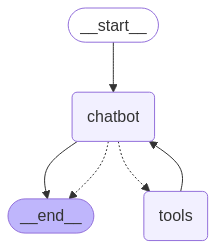

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: How can I assist you today?
Assistant: I can be used in a variety of ways, from helping you plan a vacation to creating art. I'm here to assist you in finding the help or information you need. My strengths include answering questions, generating text and images and even just chatting with you.
Assistant: I'd be happy to help create some art with you! Since I'm a text-based AI, we can create a piece of art through a combination of words and imagination.

Let's start with a theme. What kind of art would you like to create? Would you like it to be:

A) A landscape (e.g., mountain, ocean, cityscape)
B) An abstract piece
C) A portrait or still life
D) Something entirely different

Choose a letter to get started!

(If you have any specific ideas or preferences, feel free to share them, and I'll do my best to accommodate your vision.)
Assistant: A mountain!

Mountains are majestic natural wonders that can evoke a sense of awe and wonder. They are often formed through geological pro

In [17]:
from pprint import pprint
ans = llm_with_tools.invoke("What is 45*67")
pprint(ans.to_json)

<bound method Serializable.to_json of AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-04-05T14:17:29.8520816Z', 'done': True, 'done_reason': 'stop', 'total_duration': 689834100, 'load_duration': 26805000, 'prompt_eval_count': 165, 'prompt_eval_duration': 4409000, 'eval_count': 16, 'eval_duration': 656315200, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-1d7ca55c-d77e-4352-a2e9-43da32a84136-0', tool_calls=[{'name': 'multiply', 'args': {'a': 45, 'b': 67}, 'id': '3d18390c-7101-4940-8d38-d9008bb5b3b0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 165, 'output_tokens': 16, 'total_tokens': 181})>


In [18]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools([multiply])


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [20]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[multiply])
graph_builder.add_node("tools", tool_node)

In [21]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

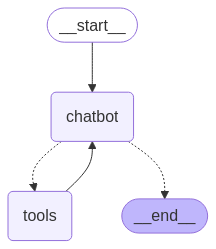

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: 6
Assistant: The result of multiplying 2 and 3 is 6. Is there anything else I can help you with?
Assistant: 
Assistant: 0
Assistant: The result of multiplying 0 by any number is 0. Is there anything else I can help you with?
Assistant: 
Assistant: 6
Assistant: The result of multiplying 2 and 3 is 6.
Goodbye!
